In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)

from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()


In [4]:
dataf_pmem = "../../data/linkedlist.pmem.csv"
dataf_gpu = "../../data/linkedlist.gpu.csv"

In [5]:
!sha256sum $dataf_pmem
!sha256sum $dataf_gpu

fa9cf7287dcdc1dde17ce56ddbbf0d885e796ecf4d23d947b89efdbe8b416de8  ../../data/linkedlist.pmem.csv
4dd61671411fb7501c0dddb5a76a11fcfb4cee48ff7a4e18a2d01352291b6a9b  ../../data/linkedlist.gpu.csv


In [6]:
df_pmem = pd.read_csv(dataf_pmem, index_col=None)
df_pmem = df_pmem.set_index('workload')
df_pmem = df_pmem/10**9

df_gpu = pd.read_csv(dataf_gpu, index_col=None)
df_gpu = df_gpu.set_index('workload')
df_gpu = df_gpu/10**9

In [7]:
df_pmem

,pmdk,snashot,msync,msync huge page,msync data journal
workload,,,,,
insert,3.795773,2.256530,65.201061,66.727555,66.101519
delete,3.791671,2.517652,63.738267,65.206676,65.629438
traverse,7.738415,0.276623,0.264363,0.266932,0.258812


In [8]:
df_gpu

,pmdk,snashot,msync
workload,,,
insert,16.138929,1.527864,NaN
delete,15.995313,0.883904,NaN
traverse,0.703281,0.000202,NaN


In [9]:
pmdk_col = df_pmem['pmdk']
df_pmem_norm = df_pmem.copy(deep=True)
for col in df_pmem:
    df_pmem_norm[col] = df_pmem[col]/pmdk_col
# del df_pmem_norm['msync']
df_pmem_norm

,pmdk,snashot,msync,msync huge page,msync data journal
workload,,,,,
insert,1.0,0.594485,17.177280,17.579436,17.414506
delete,1.0,0.663995,16.810072,17.197344,17.308841
traverse,1.0,0.035747,0.034162,0.034494,0.033445


In [10]:
figsize = (7,2.25)
fontsize = 14
Fig.config(fontsize, figsize)

Plot saved as `plots/pathfinding/linkedlist.png`

Plot saved as `plots/pathfinding/linkedlist.png`

Using pdfcrop on `plots/pathfinding/linkedlist.png` with command `pdfcrop plots/pathfinding/linkedlist.pdf plots/pathfinding/linkedlist.pdf`

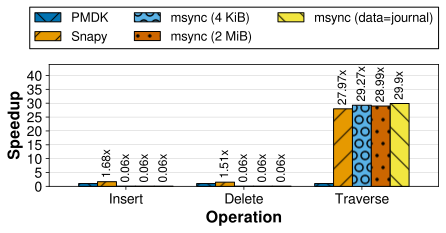

In [18]:
plt.rc('axes', unicode_minus=False)
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'freesans',
        'mathtext.fontset': 'stix',
    }
)

speedup = 1/df_pmem_norm
speedup = capitalize_index(speedup)
speedup = rename_cols(speedup, {'pmdk': 'PMDK', 'snashot': 'Snapy', 'msync': 'msync (4 KiB)', 'msync huge page': 'msync (2 MiB)', 'msync data journal': 'msync (data=journal)'})
ax = speedup.plot.bar(**Fig.get_kwargs(width=0.8))


bars = ax.patches
hatches = ''.join(h*len(speedup) for h in ['x', '/', 'O', '.', '\\', '+', '*'])

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)


f = Fig(ax)
f.fmt_legend(ncol=3, y_off_scale=1.05, x_off_scale=0.95, fontsize=13)
f.fmt_label(u'Operation', 'Speedup', fontsize=16)
ax.set_ylim((0,44))
f.add_bar_labels([False, True, True, True, True], precision=2, fontsize=fontsize-2, over_fig=False, alpha=0,
                label_move_thresh=0.0, label_off_frac=0.06, rotation=90, ha='center')
f.xrot(rot=0)
f.fmt_grid(axis='y', color='gray', linewidth=0.2)
ax.set_yticks(np.arange(0, 44.1, 5))
# ax.axline((0, 1), (10, 1), zorder=0, color='black', linewidth=0.5)
save_fig('linkedlist')